In [63]:
import pywt # type: ignore
from tsai.all import * # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import os
from contextlib import contextmanager
import numpy as np # type: ignore
from sklearn.linear_model import LinearRegression # type: ignore
from pmdarima.arima import auto_arima # type: ignore
from sklearn.model_selection import train_test_split # type: ignore

# Mudar o diretório de trabalho
# Útil para acessar outras pastas com os.listdir() e afins
@contextmanager
def cwd(path: str) -> None:
    """path = Caminho do diretório de trabalho"""
    oldpwd = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

# Função para decompor a série temporal
def wavelet_decompose(data, wavelet='db4',level=2):
    """ data = Série temporal
        wavelet = Wavelet a ser usada
        level = Nível de decomposição
        """
    coeffs = pywt.wavedec(data, wavelet, level=level)
    return coeffs

# Função para previsão usando auto_arima para encontrar o melhor modelo
def forecast_ar1(series,new_data,steps):
    """ series = Série temporal
        new_data = Novos dados para atualizar o modelo
        steps = Número de passos para prever
        """
    arima_model = auto_arima(series,
            start_p=1, start_q=1, d=None, max_p=6, max_q=6, max_d=2,
            start_P=1, start_Q=1, D=None, max_P=3, max_Q=3, max_D=2, max_order=None,
            seasonal=True, m=12, trace=True, error_action='ignore',
            suppress_warnings=True, stepwise=True
        )
    arima_model.update(new_data)
    forecast = arima_model.predict(n_periods=steps)
    return forecast

# Inicializar e treinar a rede neural
def forecast_ann(X, y,splits, X_test, name, model = LSTMPlus, epochs=200):
    """ X = Matriz de features (n° de observações, características, comprimento da série temporal)
        y = Variável target (n° de observações, comprimento da série temporal)
        splits = Índices de treino e validação
        X_test = Matriz de features de teste (n° de observações, características, comprimento da série temporal)
        name = Nome do modelo
        model = Arquitetura da rede neural. Mais informações em https://timeseriesai.github.io/tsai/
        epochs = Número de épocas
        """
    learn = TSForecaster(X, y,splits=splits, arch=model, metrics=[mae, rmse], batch_tfms=TSStandardize(), tfms=[None, [TSForecasting()]], loss_func=HuberLoss(delta=1, reduction='mean')) # type: ignore
    with ContextManagers([learn.no_logging(), learn.no_bar()]):
        lr = learn.lr_find() # Achar o melhor learning rate pro modelo, método da biblioteca fastai
        learn.fit_one_cycle(epochs, lr_max=lr.valley)
        print(f'Métricas de Treinamento para {name}')
        display(pd.Series(learn.recorder.values[-1], index=learn.recorder.metric_names[1:5],name=name))
        raw_preds, _, _ = learn.get_X_preds(X_test)
        return raw_preds


# Carregar os dados
with cwd('./gpp_novo_2002_2021/'):
    csvs = sorted(os.listdir()) # Lista com os arquivos .csv
    dados = []
    for csv in csvs:
        region = csv.split('_')[1] # Nome da região
        df = pd.read_csv(csv, index_col='index', date_format='index').rename(columns={'GPP': region})
        df.index = pd.to_datetime(df.index)
        df = df.resample('D').mean() # Resample para preencher os dias faltantes e acrescentar frequência diária
        dados.append(df)
    df = pd.concat(dados, axis=1)

In [ ]:

# Decomposição e previsão no Peru. Favor testar em outras regiões.
peru = df['peru'].copy()

peru_train, peru_test = train_test_split(peru, test_size=0.2, shuffle=False)
coeffs_train = wavelet_decompose(peru_train)
cA2_train, cD2_train, cD1_train = coeffs_train

coeffs_test = wavelet_decompose(peru_test)
cA2_test, cD2_test, cD1_test = coeffs_test

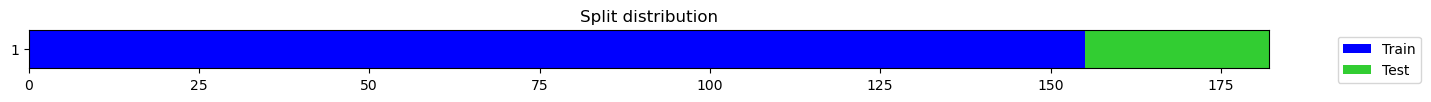

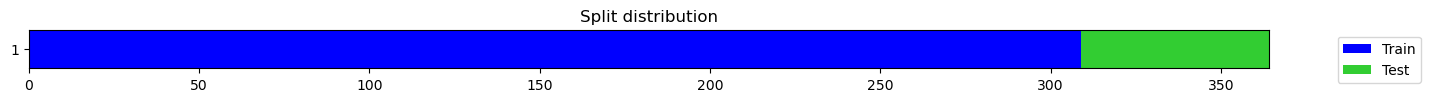

In [24]:
def create_sliding_windows(data, window_size=8, horizon=8):
    return SlidingWindow(window_size, horizon=horizon, stride=None, seq_first=True)(data) # type: ignore

# Criando janelas deslizantes para cada componente
window_size = 8
horizon = 8

# Treinamento
X_train_cD2, y_train_cD2 = create_sliding_windows(cD2_train, window_size, horizon)
X_train_cD1, y_train_cD1 = create_sliding_windows(cD1_train, window_size, horizon)

# Teste
X_test_cD2, y_test_cD2 = create_sliding_windows(cD2_test, window_size, horizon)
X_test_cD1, y_test_cD1 = create_sliding_windows(cD1_test, window_size, horizon)



# Dividindo em treino e validação para a rede neural
splits_train_val_d2 = TSSplitter(valid_size=0.15)(y_train_cD2) # type: ignore
splits_train_val_d1 = TSSplitter(valid_size=0.15)(y_train_cD1) # type: ignore



# Teste especificamente do Arima
# Dividi em X e Y para utilizar o método .update no eixo X e prever com o tamanho do eixo Y
# Tentei "simular" predições que precisam de uma atualização constante do modelo
X_test_cA2, y_test_cA2 = create_sliding_windows(cA2_test, window_size, horizon)


In [ ]:
%%capture
# Prevendo com o melhor modelo ARIMA encontrado
a2_forecast = forecast_ar1(cA2_train,new_data=X_test_cA2.flatten(),steps=len(y_test_cA2.flatten()))

Métricas de Treinamento para cD2


train_loss    0.876906
valid_loss    0.816580
mae           1.225669
_rmse         1.558754
Name: cD2, dtype: float64

Métricas de Treinamento para cD1


train_loss    0.707439
valid_loss    0.668662
mae           1.062672
_rmse         1.382242
Name: cD1, dtype: float64

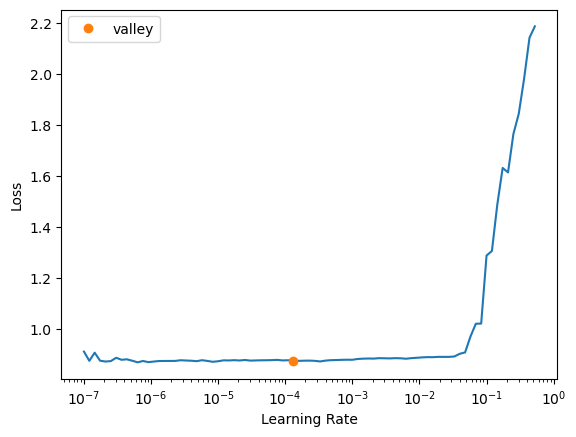

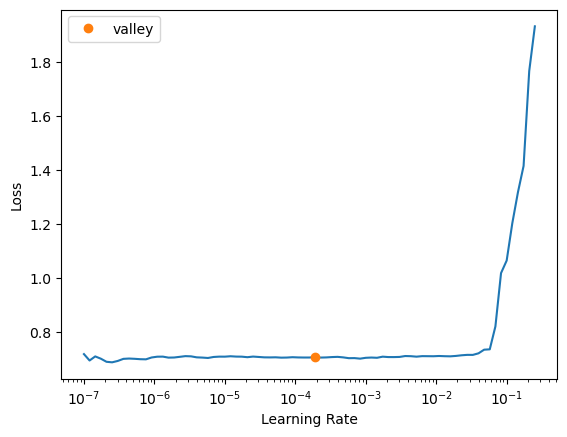

In [101]:
# Prevendo y_test_cD2
forecast_cD2 = forecast_ann(X_train_cD2, y_train_cD2, splits=splits_train_val_d2, X_test=X_test_cD2, name='cD2', model=TransformerGRUPlus, epochs= 50)

# Prevendo y_test_cD1
forecast_cD1 = forecast_ann(X_train_cD1, y_train_cD1, splits=splits_train_val_d1, X_test=X_test_cD1, name='cD1', model=TransformerGRUPlus, epochs= 50)

In [102]:
# Revertendo a decomposição
a2_test = pywt.upcoef('a', y_test_cA2.flatten(), 'db4', level=2, take=len(peru_test)) # type: ignore
d2_test = pywt.upcoef('d', y_test_cD2.flatten(), 'db4', level=2, take=len(peru_test)) # type: ignore
d1_test = pywt.upcoef('d', y_test_cD1.flatten(), 'db4', level=1, take=len(peru_test)) # type: ignore

In [103]:
a2_reconstructed = pywt.upcoef('a', a2_forecast, 'db4', level=2, take=len(peru_test)) # type: ignore
d2_reconstructed = pywt.upcoef('d', forecast_cD2.numpy().flatten(), 'db4', level=2, take=len(peru_test)) # type: ignore
d1_reconstructed = pywt.upcoef('d', forecast_cD1.numpy().flatten(), 'db4', level=1, take=len(peru_test)) # type: ignore

In [104]:
tamanho_minimo = min(len(a2_reconstructed), len(d2_reconstructed), len(d1_reconstructed))
#? Precisa ser cortado para ter o mesmo tamanho dos outros, a previsão de cada componente pode gerar mais (ou menos) valores do que o necessário

In [105]:
# Previsão refinada da série temporal original
# Regressão na matriz de soma Z com produto escalar do coeficiente angular com a matriz Y_hat
def refined_forecast(Z, Y_hat):
    model = LinearRegression(fit_intercept=False)
    model.fit(Z, Y_hat)
    beta_tilde = model.coef_.T # Coeficientes angulares, transpostos para corresponder ao formato de Y_hat
    Y_tilde = Z.dot(beta_tilde) # Produto escalar
    X_tilde = Y_tilde[0, :] # Previsão refinada X = S2 + D2 + D1

    return X_tilde


# Matriz de soma Z
Z = np.array([
    [1, 1, 1],  # X = S2 + D2 + D1
    [1, 1, 0],  # S1 = S2 + D2
    [0, 0, 1],  # D1
    [1, 0, 0],  # S2
    [0, 1, 0]   # D2
])

# Previsões independentes concatenadas
Y_hat = np.vstack([
    a2_reconstructed[:tamanho_minimo] + d2_reconstructed[:tamanho_minimo] + d1_reconstructed[:tamanho_minimo],
    a2_reconstructed[:tamanho_minimo] + d2_reconstructed[:tamanho_minimo],
    d1_reconstructed[:tamanho_minimo], 
    a2_reconstructed[:tamanho_minimo],
    d2_reconstructed[:tamanho_minimo]
])


# Previsão refinada
final_forecast = refined_forecast(Z, Y_hat)
test_values = a2_test[:tamanho_minimo] + d2_test[:tamanho_minimo] + d1_test[:tamanho_minimo]

6.716017018898741
2.088717149991171
-14.97029965000015
0.24278135852910893


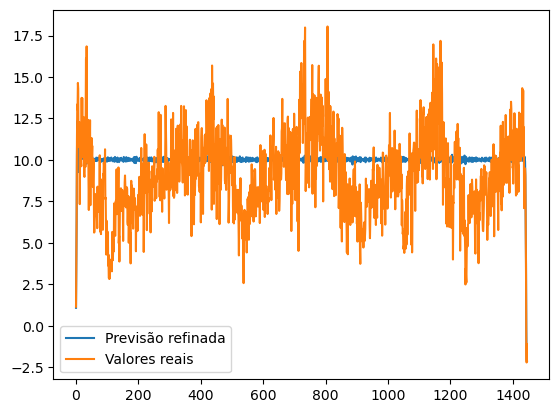

In [106]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print(mean_squared_error(final_forecast, test_values))
print(mean_absolute_error(final_forecast, test_values))
print(r2_score(final_forecast, test_values))
print(np.corrcoef(final_forecast, test_values)[0, 1])


plt.plot(final_forecast)
plt.plot(test_values)
plt.legend(['Previsão refinada', 'Valores reais'])
plt.show()